In [2]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import pickle
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import datetime
from scipy.stats import binned_statistic
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt

In [3]:
dir = '../../data/rothera/netcdfs/20230831'

In [4]:
listfiles = os.listdir(dir)
listfiles

ku_files = sorted([f for f in listfiles if 'Ku-Scat' in f])
ka_files = sorted([f for f in listfiles if 'Ka-Scat' in f])

ku_files

['kuka_stare_decon_Ku-Scat20230831-131909.nc',
 'kuka_stare_decon_Ku-Scat20230831-132410.nc',
 'kuka_stare_decon_Ku-Scat20230831-132910.nc']

Text(0, 0.5, 'y distance (m)')

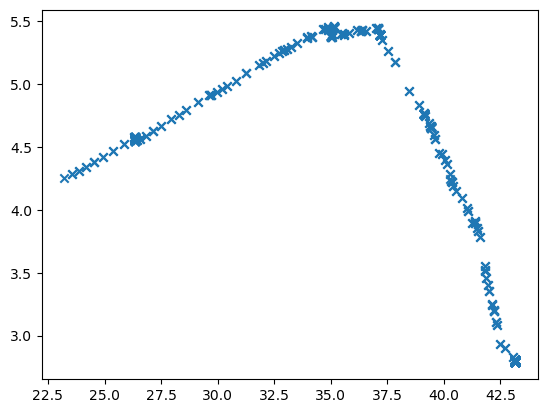

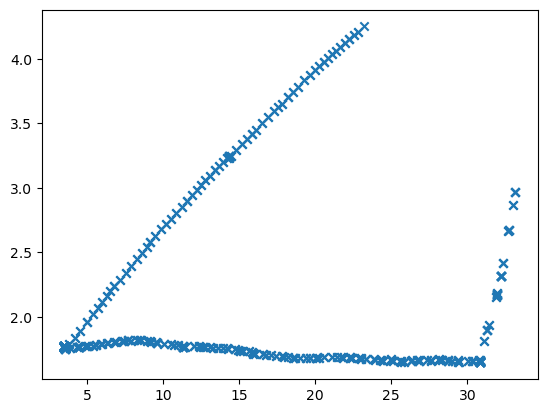

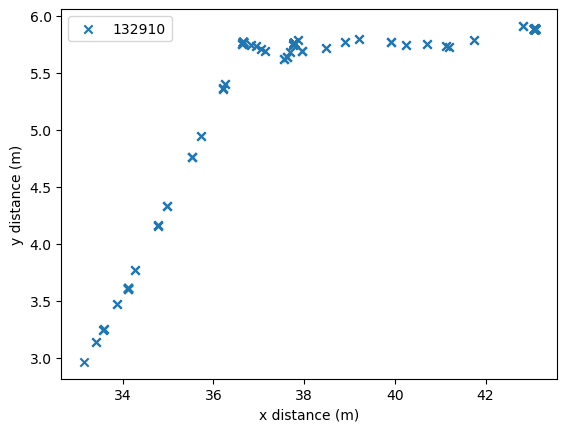

In [5]:

x,y=kt.plot_pos(ku_files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531

xy_dict = {}

for f in ku_files:

    x,y = kt.plot_pos(f,dir,x0=x0,y0=y0)

    xy_dict[f] = (x,y)
    
plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')

# plt.xlim(-20,5)
# plt.ylim(-20,5)

In [6]:
for f in ku_files[0:2]:
    x,y = xy_dict[f]
    print(np.argmin(x),np.argmax(y))
    time_offset_s=0

642 461
270 0


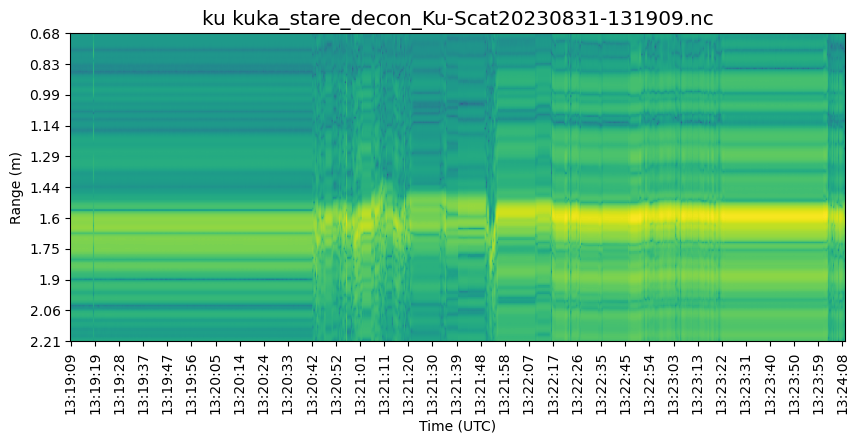

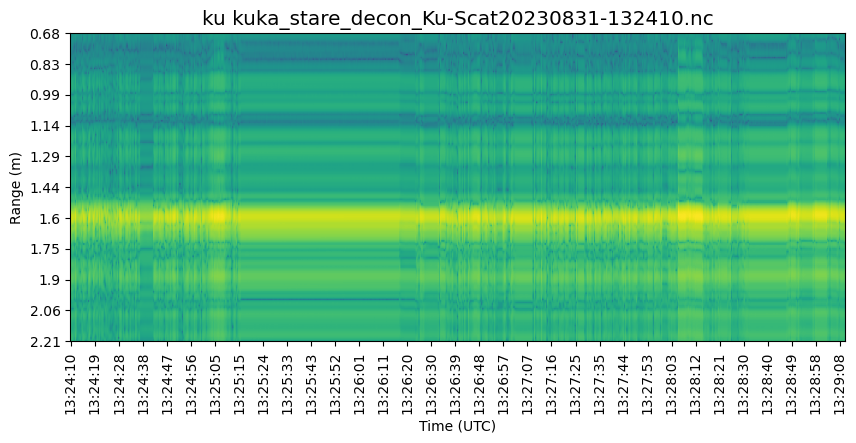

In [7]:
for f in ku_files[0:2]:
    kt.plot_file(f,'ku',dir,)
    

# Plot first file
## Start analysis at ind = 461 which is max y

In [8]:
# foi = ku_files[0]
# d = Dataset(f'{dir}/{foi}')
# x,y = xy_dict[foi]

# range = np.array(d['range'])

# times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

# mintime=461
# maxtime=-1

# x_ = 0; y_ = 0

# along_track = np.sqrt((x-x_)**2 + (y-y_)**2)

# minrange, maxrange = kt.get_range_index(1.3,range),kt.get_range_index(2,range)

# pol = 'vv'

# vv_power = np.array(d[f'{pol}_power_decon0'])
# vv_power_in_range = np.sum(vv_power[minrange:maxrange],axis=0)
# plt.plot(along_track[mintime:maxtime],vv_power_in_range[mintime:maxtime])

# plt.show()


# bin_centres = np.arange(0.25,26.01,0.5)

# plt.plot(bin_centres,bs[0])

# mean = np.nanmean(bs[0][bin_centres<20])

# plt.plot([0,20],[mean,mean],color='k',ls='--')

# print(mean)

# plt.show()


# Now plot second file, beginning at min(x) which is index 270

In [18]:
foi = ku_files[1]
d = Dataset(f'{dir}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

mintime = kt.get_time_index(datetime.datetime(2023,8,31,13,26,20),times)
mintime = 270
# maxtime = kt.get_time_index(datetime.datetime(2023,8,31,13,29,8),times)
maxtime=-1

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)+2

xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]

nrcs = pd.DataFrame(kt.get_nrcs(d,'ku'))


nrcs['along_track']=along_track
nrcs['speed']=speed

nrcs = nrcs[nrcs['corr']<0.999999999]
nrcs.reset_index(inplace=True,drop=True)



nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return.sort_values('along_track').reset_index(drop=True)

nrcs_return = nrcs_return[nrcs_return['along_track']<30]

nrcs_return

,vv,hv,vh,hh,corr,along_track,speed
0,2.116922,0.001256,0.004395,2.721474,1.000000,5.928716,0.000000
1,2.113729,0.001249,0.004388,2.732704,1.000000,5.928716,0.002297
2,2.115861,0.001249,0.004389,2.722562,1.000000,5.930726,0.000000
3,2.115668,0.001251,0.004386,2.720703,0.992137,5.930726,0.025356
4,1.621771,0.003296,0.007016,2.116329,0.992391,5.951163,0.000000
...,...,...,...,...,...,...,...
259,1.873697,0.018980,0.018167,2.077015,0.996178,29.641220,0.000000
260,2.748798,0.009588,0.010013,3.235555,0.999095,29.641220,0.000000
261,2.790972,0.008234,0.008377,3.310066,0.996434,29.641220,0.024833
262,1.233461,0.001857,0.002593,1.307887,0.969165,29.665632,0.000000


In [19]:
power_threshold = np.max(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold_arg = np.argmax(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold,power_threshold_arg

(8.609058102917505, 122)

In [20]:
start_ind = np.argmax(nrcs_return['vv']>power_threshold)
start_along_track = nrcs_return['along_track'].iloc[start_ind]

nrcs_reverse = nrcs_return.reindex(index=nrcs_return.index[::-1])
end_ind = np.argmax(nrcs_reverse['vv']>power_threshold)
end_along_track = nrcs_reverse['along_track'].iloc[end_ind]
start_along_track,end_along_track

(27.632723993633554, 28.895398630415986)

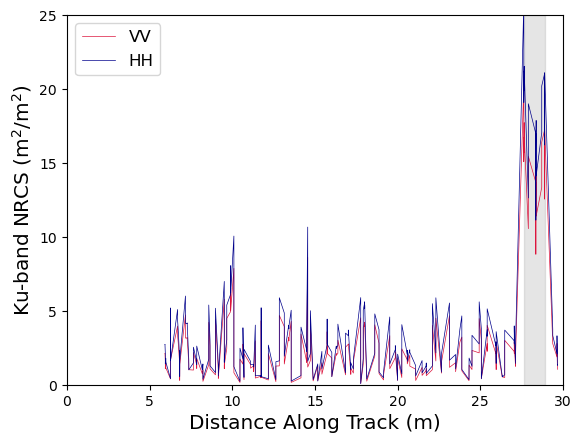

In [21]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,25)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [13]:
ff_pickles = '/home/robbie/Dropbox/kuka_bare/data/pickles/FF_fig'
pickle.dump((nrcs_return,
             start_along_track,
             end_along_track),
            open(f'{ff_pickles}/ku31.p','wb'))

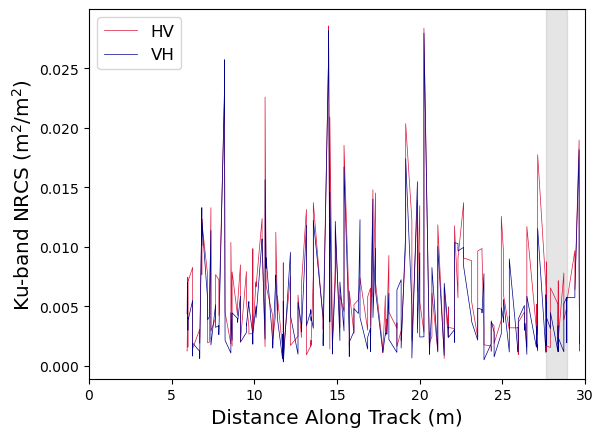

In [49]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['hv'],
         label='HV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['vh'],
         label='VH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')

plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
# plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [50]:
pickle.dump(nrcs_return,open('../../data/pickles/NRCS_831_KU.p','wb'))
start_along_track,end_along_track

(27.632723993633554, 28.895398630415986)